In [1]:
pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.4/499.4 kB 11.9 MB/s eta 0:00:0000:01
  Attempting uninstall: pytz
    Found existing installation: pytz 2022.1
    Uninstalling pytz-2022.1:
      Successfully uninstalled pytz-2022.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
pandas-profiling 3.1.0 requires markupsafe~=2.0.1, but you have markupsafe 2.1.1 which is incompatible.
apache-beam 2.40.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.5.1 which is incompatible.
apache-beam 2.40.0 requires pyarrow<8.0.0,>=0.15.1, but you have pyarrow 8.0.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install yahooquery

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 2.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Raw Package
import numpy as np
import pandas as pd

#Data Source
import yfinance as yf

#Data viz
import plotly.graph_objs as go

from re import search
from yahooquery import Screener

In [4]:
def getRates(ticker_input ,period_input  ,interval_input ):
    print(ticker_input+" "+period_input+" "+interval_input )
    data = yf.download(tickers=ticker_input, period = period_input, interval = interval_input)
    return data["Close"]

In [5]:
def getPercChange(d):
    x=round(d.head(1),6).values
    y=round(d.tail(1),6).values
    perc_chg= np.round( (  (y-x) / abs(x)  ) *100  , 4)
    return perc_chg

In [6]:
def mail2me(pair_text,message_text):
    from email.message import EmailMessage
    import smtplib
    from pretty_html_table import build_table

    sender = "ozukun83@gmail.com"
    recipient = "ozukun83@gmail.com"
    message = "Crypto Info all"

    password = input("Type your password and press enter: ")
    
    email = EmailMessage()
    email["From"] = sender
    email["To"] = recipient
    email["Subject"] = "Crypto Rates Python!"+"  "+pair_text
    email.set_content(message_text)

    
    
    smtp = smtplib.SMTP_SSL("smtp.gmail.com")
    smtp.login(sender, password)
    smtp.sendmail(sender, recipient, email.as_string())
    smtp.quit()
    print("Mail succeed !!")

In [7]:
# get all crypto pairs with USD
def getCryptoPairs():
    s = Screener()
    tickers=[]
    data = s.get_screeners('all_cryptocurrencies_us', count=10)

    # data is in the quotes key
    dicts = data['all_cryptocurrencies_us']['quotes']
    symbols = [d['symbol'] for d in dicts]
    symbols[0]

    for s in symbols:
        if  search("USD", s) and not search("USDT", s) and not search("USDC", s): #\
        #and ( search("ETH",s) or search("DOGE",s) ):
            #print(s+"\n")
            tickers.append(s)
             
    return tickers
        

for cp in getCryptoPairs():
    print(cp)

BTC-USD
ETH-USD
BNB-USD
XRP-USD
BUSD-USD
DOGE-USD
ADA-USD
MATIC-USD


In [8]:
Crypto_Pairs=["BTC-USD","ETH-USD"]

message_input=""
final_message=""
for cp in Crypto_Pairs:
    print(cp)
    df_tmp=getRates(cp,  '3mo',  '1h')
    message_input=cp+"   First: "+str( round( df_tmp.head(1)[0] ,6 ) )+"  "+"Last: "+str( round(df_tmp.tail(1)[0] ,6)  )
    df3mo=getRates(cp,  '3mo',  '1h')
    message_input0=cp+"  '3mo',  '1h' CHANGE % " +str( getPercChange(df3mo)[0])
    
    df1mo=getRates(cp,  '1mo',  '1h')
    message_input1=cp+"  '1mo',  '1h' CHANGE % " +str( getPercChange(df1mo)[0])
    
    dfwk=getRates(cp,'1wk',  '1h')
    message_input2=cp+"  '1wk',  '1h' CHANGE % " +str( getPercChange(dfwk)[0])
    
    message_input=message_input+"\n"+message_input0+"\n"+message_input1+"\n"+message_input2+"\n"+"\n"
    final_message=final_message+message_input
    print(final_message)
    
    
#mail2me("All Crypto Pairs",final_message)

BTC-USD
BTC-USD 3mo 1h
[*********************100%***********************]  1 of 1 completed
BTC-USD 3mo 1h
[*********************100%***********************]  1 of 1 completed
BTC-USD 1mo 1h
[*********************100%***********************]  1 of 1 completed
BTC-USD 1wk 1h
[*********************100%***********************]  1 of 1 completed
BTC-USD   First: 20336.826172  Last: 16839.388672
BTC-USD  '3mo',  '1h' CHANGE % -17.1976
BTC-USD  '1mo',  '1h' CHANGE % -1.7117
BTC-USD  '1wk',  '1h' CHANGE % 1.747


ETH-USD
ETH-USD 3mo 1h
[*********************100%***********************]  1 of 1 completed
ETH-USD 3mo 1h
[*********************100%***********************]  1 of 1 completed
ETH-USD 1mo 1h
[*********************100%***********************]  1 of 1 completed
ETH-USD 1wk 1h
[*********************100%***********************]  1 of 1 completed
BTC-USD   First: 20336.826172  Last: 16839.388672
BTC-USD  '3mo',  '1h' CHANGE % -17.1976
BTC-USD  '1mo',  '1h' CHANGE % -1.7117
BTC-USD  '1wk',

In [9]:
def getRatesTable(*args):
    df_table = pd.DataFrame()
    for cp in args:
        df10yr=getRates(cp, '10y',  '1d')
        df5yr=getRates(cp,  '5y',  '1d')
        df3yr=getRates(cp,  '3y',  '1d')
        df1yr=getRates(cp,  '1y',  '1d')
        df3mo=getRates(cp,  '3mo',  '1h')
        df1mo=getRates(cp,  '1mo',  '1h')
        df1wk=getRates(cp,  '1wk',  '1h')
        df1dy=getRates(cp,  '1dy',  '1h')
        new_row = pd.Series(data={
                                   'Crypto_Pair':cp,
                                   '10yr_d_CHG%':getPercChange(df10yr)[0],
                                   '5yr_d_CHG%':getPercChange(df5yr)[0],
                                   '3yr_d_CHG%':getPercChange(df3yr)[0],
                                   '1yr_d_CHG%':getPercChange(df1yr)[0], 
                                   '3mo_h_CHG%':getPercChange(df3mo)[0], 
                                   '1mo_h_CHG%':getPercChange(df1mo)[0] ,
                                   '1wk_h_CHG%':getPercChange(df1wk)[0],
                                   '1dy_h_CHG%':getPercChange(df1dy)[0], 
                                 } 
                           )
        
        df_table = df_table.append(new_row, ignore_index=True)
    return df_table

#--------------------------------------------------------------------


Crypto_Pairs=["BTC-USD","ETH-USD","ALGO-USD","SOL-USD","LUNC-USD","ROSE-USD","SHIB-USD","XRP-USD","ADA-USD"]

dfx=getRatesTable(*Crypto_Pairs)

dfx

BTC-USD 10y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 5y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 3y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 3mo 1h
[*********************100%***********************]  1 of 1 completed
BTC-USD 1mo 1h
[*********************100%***********************]  1 of 1 completed
BTC-USD 1wk 1h
[*********************100%***********************]  1 of 1 completed
BTC-USD 1dy 1h
[*********************100%***********************]  1 of 1 completed
ETH-USD 10y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 5y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 3y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 1y 1d
[*********************100%***********************]  1 of 1 complete

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


[*********************100%***********************]  1 of 1 completed
XRP-USD 3y 1d
[*********************100%***********************]  1 of 1 completed
XRP-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
XRP-USD 3mo 1h
[*********************100%***********************]  1 of 1 completed
XRP-USD 1mo 1h
[*********************100%***********************]  1 of 1 completed
XRP-USD 1wk 1h
[*********************100%***********************]  1 of 1 completed
XRP-USD 1dy 1h
[*********************100%***********************]  1 of 1 completed
ADA-USD 10y 1d
[*********************100%***********************]  1 of 1 completed
ADA-USD 5y 1d
[*********************100%***********************]  1 of 1 completed
ADA-USD 3y 1d
[*********************100%***********************]  1 of 1 completed
ADA-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
ADA-USD 3mo 1h
[*********************100%***********************]  1 of 1 completed
ADA-USD 1mo 

,Crypto_Pair,10yr_d_CHG%,5yr_d_CHG%,3yr_d_CHG%,1yr_d_CHG%,3mo_h_CHG%,1mo_h_CHG%,1wk_h_CHG%,1dy_h_CHG%
0,BTC-USD,3582.0766,7.9503,127.2321,-63.3109,-17.1976,-1.7117,1.7470,1.0166
1,ETH-USD,290.7110,27.8113,828.2113,-66.9554,-7.9635,-2.0715,5.3538,3.3261
2,ALGO-USD,-94.1801,-94.1801,-21.1793,-88.8744,-47.8676,-22.4234,11.4176,0.9761
3,SOL-USD,1328.2929,1328.2929,1328.2929,-91.9114,-60.1922,-0.9933,39.2298,-0.1003
4,LUNC-USD,-99.9880,-99.9880,-99.9352,-99.9998,-42.2794,-10.7955,6.0811,0.6410
5,ROSE-USD,-4.2595,-4.2595,-4.2595,-90.9106,-40.1923,-22.4834,2.6123,2.6786
6,SHIB-USD,inf,inf,inf,-75.0000,-33.3333,-11.1111,0.0000,0.0000
7,XRP-USD,59.3780,-89.1565,78.3479,-57.9678,-27.8183,-11.2896,-2.7820,0.9897
8,ADA-USD,731.0985,-76.0895,670.0304,-79.6904,-38.8765,-17.4685,7.2518,5.5955


In [10]:
def mail2me_v2(df,mail_subject,message_text):
    
    from email.mime.text import MIMEText
    from email.mime.application import MIMEApplication
    from email.mime.multipart import MIMEMultipart
    from smtplib import SMTP
    import smtplib
    import sys


    recipients = ['ozukun83@gmail.com'] 
    emaillist = [elem.strip().split(',') for elem in recipients]
    msg = MIMEMultipart()
    msg['Subject'] = mail_subject
    msg['From'] = 'ozukun83@gmail.com'

    password = input("Type your password and press enter: ")
    

    html = """\
    <html>
      <head></head>
      <body>
        {0}
      </body>
    </html>
    """.format(df.to_html())

    part1 = MIMEText(html, 'html')
    msg.attach(part1)
    body = message_text
    body = MIMEText(body) # convert the body to a MIME compatible string
    msg.attach(body)

    server = smtplib.SMTP('smtp.gmail.com', 587)
    server.ehlo()
    server.starttls()
    server.ehlo()
    server.login("ozukun83@gmail.com",password)
    server.sendmail(msg['From'], emaillist , msg.as_string())
    print("Mail succeed !!")
    
#---------------------------------------------------------------------------
#mail2me_v2(dfx,"Crypto Rate changes","")

In [58]:
# moving average
def get_ma(prices, rate):
    return prices.rolling(rate).mean()



def get_bollinger_bands(prices, rate=7):
    sma = get_ma(prices, rate)
    std = prices.rolling(rate).std()
    bollinger_up = sma + std * 2 # Calculate top band
    bollinger_down = sma - std * 2 # Calculate bottom band
    return bollinger_up, bollinger_down


def get_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    
    macd = pd.DataFrame(exp1 - exp2)
    macd.columns=["macd"]
    
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean())
    signal.columns=["signal"]
    
    hist = pd.DataFrame(macd['macd'] - signal['signal'])
    hist.columns=["hist"]
    
    frames =  [macd, signal, hist]
    df = pd.concat(frames, join = 'inner', axis = 1)
    return df


x = get_macd(getRates("ALGO-USD",  '1y',  '1d'), 26, 12, 9)
x.tail()

#---------------------------------------------------------------


df_tmp_f = pd.DataFrame()
final_text=""
Crypto_Pairs=["ALGO-USD","LUNC-USD"]


for cp in Crypto_Pairs:

    df_tmp_0 = pd.DataFrame(getRates(cp,  '1y',  '1d'))

    bollinger_up, bollinger_down = get_bollinger_bands(df_tmp_0)

    cp_macd=get_macd(getRates(cp,  '1y',  '1d'), 26, 12, 9)
    
    display(cp_macd)

    df_tmp = pd.DataFrame(data=np.column_stack((df_tmp_0.values,bollinger_up,bollinger_down)),columns=['Price','Bol_Up','Bol_Down'])
    df_tmp.insert(0,'Crypto_Pair',cp)
    df_tmp.index=df_tmp_0.index


    display( df_tmp.iloc[-7:] )
    
    x=round( df_tmp["Bol_Up"].iloc[-30:].mean() ,6 )
    print("Bol_Up__Mean_for_last_7days   : " + str( x ) )
    
    
    y=round( df_tmp["Bol_Down"].iloc[-30:].mean() ,6 )
    print("Bol_Down__Mean_for_last_7days : " + str( y ) )
    
    x1="Bol_Up__Mean_for_last_7days   : " + str( x )
    y1="Bol_Down__Mean_for_last_7days : " + str( y )
    
    df_tmp_f = df_tmp_f.append(df_tmp.iloc[-7:])
    final_text=final_text+"\n"+cp+"\n"+str(x1)+"\n"+str(y1)
#---------------------------------------------------------------------------
#mail2me_v2(df_tmp_f,"Crypto Bollinger bands",final_text)

ALGO-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
ALGO-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
ALGO-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,macd,signal,hist
Date,,,
2022-01-05,0.000000,0.000000,0.000000
2022-01-06,0.000544,0.000109,0.000435
2022-01-07,-0.009041,-0.001721,-0.007320
2022-01-08,-0.020748,-0.005527,-0.015222
2022-01-09,-0.028516,-0.010124,-0.018391
...,...,...,...
2022-12-31,-0.017793,-0.019986,0.002193
2023-01-01,-0.016234,-0.019235,0.003002
2023-01-02,-0.014530,-0.018294,0.003764


,Crypto_Pair,Price,Bol_Up,Bol_Down
Date,,,,
2022-12-29,ALGO-USD,0.165151,0.173034,0.163607
2022-12-30,ALGO-USD,0.169008,0.172661,0.163662
2022-12-31,ALGO-USD,0.172818,0.174522,0.163069
2023-01-01,ALGO-USD,0.177466,0.178478,0.162426
2023-01-02,ALGO-USD,0.181194,0.183311,0.160362
2023-01-03,ALGO-USD,0.184302,0.188491,0.159274
2023-01-05,ALGO-USD,0.186955,0.192852,0.160547


Bol_Up__Mean_for_last_7days   : 0.212162
Bol_Down__Mean_for_last_7days : 0.182532
LUNC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
LUNC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,macd,signal,hist
Date,,,
2022-01-05,0.000000,0.000000,0.000000
2022-01-06,-0.012267,-0.002453,-0.009814
2022-01-07,-0.801077,-0.162178,-0.638899
2022-01-08,-1.548632,-0.439469,-1.109163
2022-01-09,-1.514941,-0.654563,-0.860378
...,...,...,...
2022-12-31,-0.000006,-0.000008,0.000002
2023-01-01,-0.000005,-0.000007,0.000002
2023-01-02,-0.000004,-0.000007,0.000003


,Crypto_Pair,Price,Bol_Up,Bol_Down
Date,,,,
2022-12-29,LUNC-USD,0.000150,0.000172,0.000132
2022-12-30,LUNC-USD,0.000143,0.000172,0.000133
2022-12-31,LUNC-USD,0.000145,0.000172,0.000133
2023-01-01,LUNC-USD,0.000150,0.000172,0.000134
2023-01-02,LUNC-USD,0.000160,0.000171,0.000134
2023-01-03,LUNC-USD,0.000156,0.000157,0.000144
2023-01-05,LUNC-USD,0.000158,0.000160,0.000143


Bol_Up__Mean_for_last_7days   : 0.000168
Bol_Down__Mean_for_last_7days : 0.000144


In [12]:
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

def getLine(df_input):
    x = df_input.index
    y = df_input.values
    fig = go.Figure(data=go.Scatter(x = x, y = y))
    fig.show()

ETH-USD 1d 1h
[*********************100%***********************]  1 of 1 completed


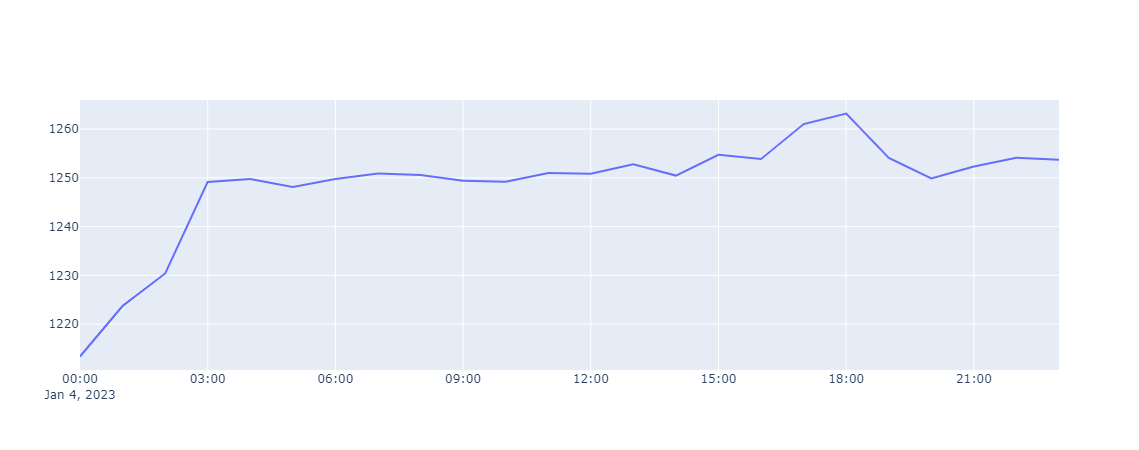

ETH-USD 1wk 1h
[*********************100%***********************]  1 of 1 completed


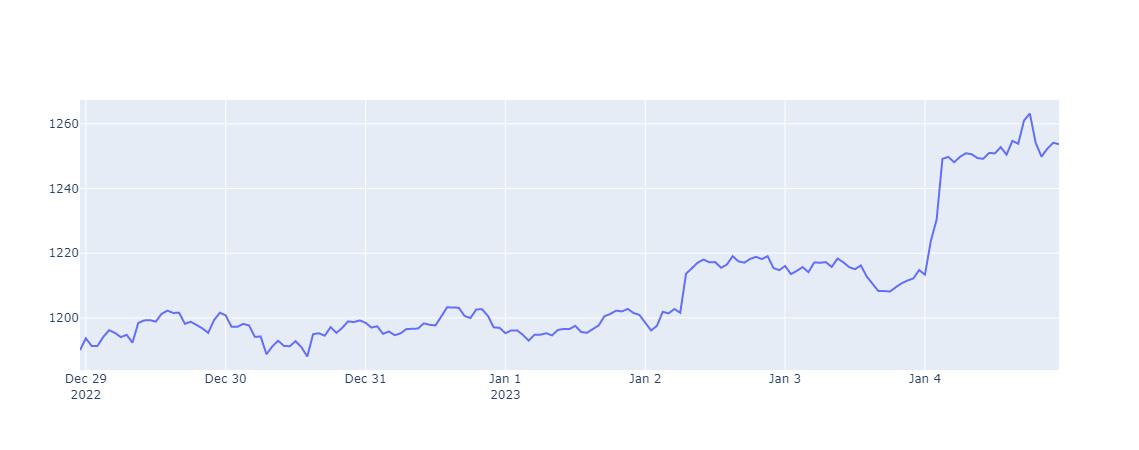

ETH-USD 3mo 1h
[*********************100%***********************]  1 of 1 completed


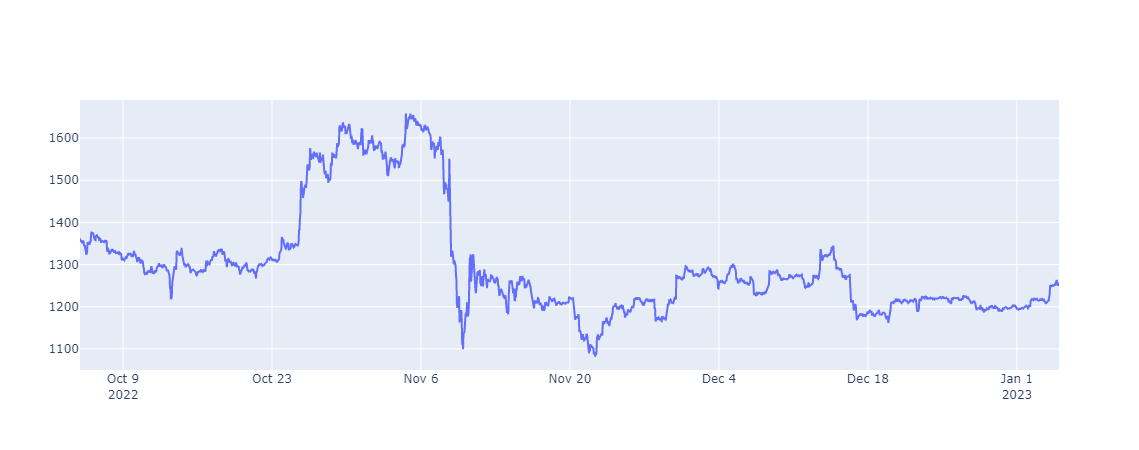

ETH-USD 3y 1d
[*********************100%***********************]  1 of 1 completed


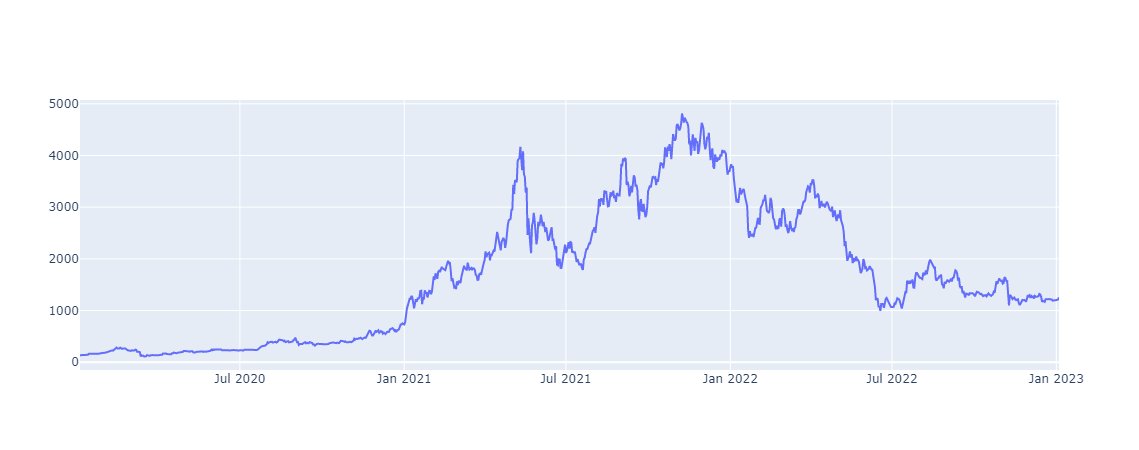

In [13]:
( getLine(getRates('ETH-USD',  '1d',  '1h')) )
( getLine(getRates('ETH-USD',  '1wk',  '1h')) )
( getLine(getRates('ETH-USD',  '3mo',  '1h')) )
( getLine(getRates('ETH-USD',  '3y',  '1d')) )